### Neste projeto, vamos dar uma de Dr. House e usar o TensorFlow Keras para treinar um modelo capaz de diagnosticar (classificar) imagens de c√©lular com e sem Leucemia.

In [10]:
# Primeiramente, vamos definir o diret√≥rio onde est√£o as imagens
data_dir= Path(r'C:\Users\gilbe\Downloads\Imagens')

In [13]:
# Vamos solicitar ao instrumentador cir√∫rgico para preparar  as ferramentas que ser√£o utilizadas no projeto
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from pathlib import Path

#####  Vamos verificar como essas imagens est√£o organizadas
##### As imagens est√£o em uma pasta do disco, separadas em subpastas, representando as duas classes de c√©lulas.

In [17]:
# Vamos contar quantas imagens temos no total

img_count = len(list(data_dir.glob('*/*.jpg')))
print(img_count)

5460


In [46]:
# No total, s√£o 5460 imagens, 50% de classe 'Leucemia' e 50% da classe 'Saud√°vel'
list(data_dir.glob('*/'))

[WindowsPath('C:/Users/gilbe/Downloads/Imagens/Leucemia'),
 WindowsPath('C:/Users/gilbe/Downloads/Imagens/Saudavel')]

In [47]:
print(len(list(data_dir.glob('Leucemia/*'))))
print(len(list(data_dir.glob('Saudavel/*'))))

2730
2730


##### Vamos dar uma olhada em algumas dessas imagens

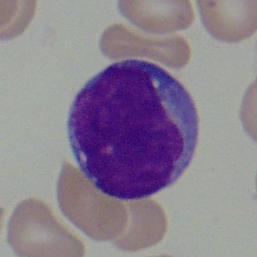

In [56]:
leucemia = list(data_dir.glob('Leucemia/*'))
PIL.Image.open(str(leucemia[0]))

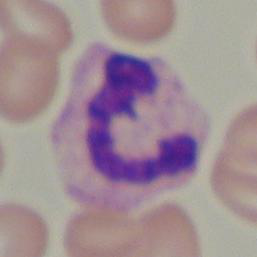

In [57]:
saudavel = list(data_dir.glob('Saudavel/*'))
PIL.Image.open(str(saudavel[0]))

##### Hora de carregar essas imagens para o Keras

In [58]:
# Vamos antes definir alguns par√¢metros para o carregador:
batch_size = 32
img_height = 180
img_width = 180

##### Vamos dividir nossos dados em grupos de treino e de valida√ß√£o. Como dispomos de muitos exemplos, vou aplicar a propor√ß√£o 80/20
##### 80% para treinar o modelo e 20% para avali√°-lo.

In [61]:
dados_treino = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=21,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5460 files belonging to 2 classes.
Using 4368 files for training.


In [62]:
dados_teste = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="validation",
    seed = 21,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 5460 files belonging to 2 classes.
Using 1092 files for validation.


#### Vamos usar o MatplotLib para vizualizar algumas imagens do conjunto de treinamento

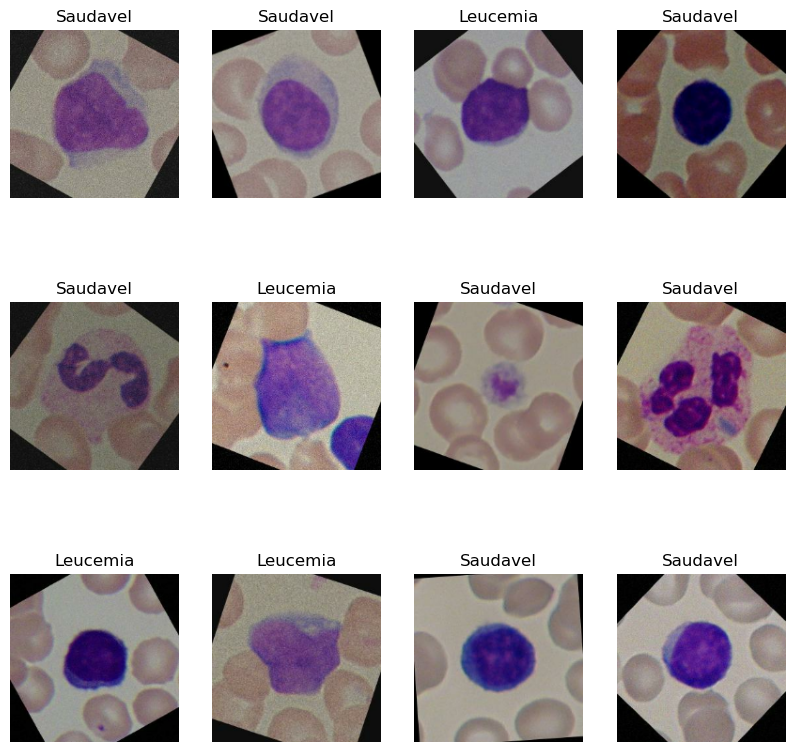

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for img, lbl in dados_treino.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(dados_treino.class_names[lbl[i]])
        plt.axis("off")

#### O par√¢metro batch_size que definimos acima serve para definir o tamanho dos lotes de imagens.

In [76]:
dados_treino

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Esses lotes tem formato 180 x 180 x 3.
#### Essa √∫ltima dimens√£o representa os canais de cores RGB.
#### A escala RGB varia entre 0 (preto) at√© 255 (branco). Isso n√£o √© interessante para n√≥s, j√° que vamos utilizar uma rede neural.
#### Precisamos alimentar nossa Neural Network com valores de entrada pequenos

#### Para fazer isso, vamos normalizar essa dimens√£o dos nossos dados com o Keras.

In [78]:
camada_normalizada = tf.keras.layers.Rescaling(1./255)

#### Veja que ap√≥s a normaliza√ß√£o, os dados est√£o agora dentro do intervalo entre 0 e 1

In [82]:
data_normalized = dados_treino.map(lambda x, y: (camada_normalizada(x),y))
img_batch, labels_batch = next(iter(data_normalized))
first_image = img_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.7780444


#### Certo, agora, estamos com quase tudo pronto para iniciar o treinamento do nosso modelo.
#### No entanto, precisamos estar atentos a um detalhe importante:

#### Esse tipo de tarefa (Vis√£o Computacional) consome muitos recursos de processamento.
#### Precisamos garantir que a leitura dos dados que est√£o no disco n√£o inviabilizem a execu√ß√£o ao tornar-se um gargalo.

#### Veja o que a documenta√ß√£o do Keras tem a nos dizer a esse respeito:

Dataset.cache mant√©m as imagens na mem√≥ria depois de serem carregadas fora do disco durante a primeira √©poca. Isso garantir√° que o conjunto de dados n√£o se torne um gargalo ao treinar seu modelo. Se seu conjunto de dados for muito grande para caber na mem√≥ria, voc√™ tamb√©m poder√° usar esse m√©todo para criar um cache em disco de alto desempenho.

Dataset.prefetch sobrep√µe o pr√©-processamento de dados e a execu√ß√£o do modelo durante o treinamento.

In [83]:
AUTOTUNE = tf.data.AUTOTUNE

dados_treino = dados_treino.cache().prefetch(buffer_size=AUTOTUNE)
dados_teste = dados_teste.cache().prefetch(buffer_size=AUTOTUNE)

## Treinando o modelo

#### Vamos utilizar o modelo Sequencial do Keras: uma rede neural composta de tr√™s blocos de convolu√ß√£o,  uma camada de de agrupamento m√°ximo em cada um deles e uma camada densa.

#### A fun√ß√£o de ativa√ß√£o ReLu √© um elemento essencial para nossa rede neural. 

####Essa fun√ß√£o consiste em preservar valores positivos e transformar valores negativos em zeros. A convers√£o √© r√°pida mas se a ocorr√™ncia de sa√≠das negativas for alta muitos neur√¥nios n√£o ser√£o ativados: 
ùëî(ùëß)={0,ùëß<0ùëß,ùëß‚â•0 

#### Tamb√©m usaremos o otimizador Adam e a fun√ß√£o de perda SparseCategoricalCrossEntropy

In [84]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [85]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Vamos treinar o modelo!

In [88]:
model.fit(
  dados_treino,
  validation_data=dados_teste,
  epochs=4
)

Epoch 1/4
137/137 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 54s 396ms/step - accuracy: 0.9340 - loss: 0.1520 - val_accuracy: 0.9396 - val_loss: 0.1621
Epoch 2/4
137/137 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56s 406ms/step - accuracy: 0.9523 - loss: 0.1213 - val_accuracy: 0.9386 - val_loss: 0.1695
Epoch 3/4
137/137 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 55s 403ms/step - accuracy: 0.9616 - loss: 0.1016 - val_accuracy: 0.9441 - val_loss: 0.1153
Epoch 4/4
137/137 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 61s 443ms/step - accuracy: 0.9663 - loss: 0.0831 - val_accuracy: 0.9679 - val_loss: 0.0913


#### Com 4 √©pocas de treinamento, alcan√ßamos 96% de acur√°cia na etapa de treinamento.

In [92]:
model.evaluate(dados_teste, verbose = "auto")

35/35 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 74ms/step - accuracy: 0.9660 - loss: 0.0966


[0.0912761315703392, 0.9679487347602844]

## Conclus√£o

#### Usando um notebook HP com processador i5 e 8GB de RAM, consegui implementar uma rede neural para classifica√ß√£o de c√©lulas saud√°veis ou com Leucemia.

#### √â claro que em se tratando de medicina, testes mais rigorosos devem ser aplicados, mas n√£o entrarei nesse m√©rito.

#### Meu objetivo foi demonstrar como a Intelig√™ncia Artificial pode ser aplicada no contexto da medicina e trazer bons resultados para todos n√≥s.